In [2]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dataAnalyse import CCV2
from torch_geometric.data import DataLoader 
from model_3DEC import Net
#from torch_geometric.nn import knn_graph

import numpy as np
import awkward as ak
import time
#from Imports import Aggloremative, calculate_reco_to_sim_score, calculate_sim_to_reco_score_without_squares, calculate_sim_to_reco_score, calculate_all_event_scores

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [29]:
# new imports


def calculate_reco_to_sim_score(ReconstructedTrackster, energies_indices, CaloParticle, track_mult, calo_mult):
    """
    Calculate the reco-to-sim score for a given ReconstructedTrackster and CaloParticle.

    Parameters:
    - ReconstructedTrackster: array of DetIds in the ReconstructedTrackster.
    - energies_indices: array of energies associated with all DetIds (indexed by DetId).
    - CaloParticle: array of DetIds in the CaloParticle.

    Returns:
    - reco_to_sim_score: the calculated reco-to-sim score.
    """
    numerator = 0.0
    denominator = 0.0
    sharedEnergy = 0.0

    # Iterate over all DetIds in the ReconstructedTrackster
    for i, det_id in enumerate(ReconstructedTrackster):
        energy_k = energies_indices[det_id]  # Energy for the current DetId in the Trackster
        
        # Fraction of energy in the Trackster (fr_k^TST)
        fr_tst_k = 1 / track_mult[i]

        #Fraction of energy in the caloparticle
        if det_id in CaloParticle:
            index = np.where(CaloParticle == det_id)[0][0]
            fr_sc_k = 1 / calo_mult[index]
            
        else:
            fr_sc_k = 0 # binary function also for CaloParticle
            
        # Update numerator using the min function
        numerator += min(
            (fr_tst_k - fr_sc_k) ** 2,  # First term in the min function
            fr_tst_k ** 2               # Second term in the min function
        ) * (energy_k ** 2)

        # Update denominator
        denominator += (fr_tst_k ** 2) * (energy_k ** 2)
        
        #shared_energy calculation
        recosharedEnergy = energy_k * fr_tst_k
        simsharedEnergy = energy_k * fr_sc_k
        sharedEnergy += min(simsharedEnergy,recosharedEnergy)
        
        

    # Calculate score
    reco_to_sim_score = numerator / denominator if denominator != 0 else 1.0
    return reco_to_sim_score, sharedEnergy



def calculate_sim_to_reco_score(CaloParticle, energies_indices, ReconstructedTrackster, track_mult, calo_mult):
    """
    Calculate the sim-to-reco score for a given CaloParticle and ReconstructedTrackster.
    
    Parameters:
    - CaloParticle: array of Layer Clusters in the CaloParticle.
    - Multiplicity: array of Multiplicity for layer clusters in CP
    - energies_indices: array of energies associated with all LC (indexed by LC).
    - ReconstructedTrackster: array of LC in the reconstructed Trackster.
    
    Returns:
    - sim_to_reco_score: the calculated sim-to-reco score.
    """
    numerator = 0.0
    denominator = 0.0

    # Iterate over all DetIds in the CaloParticle
    for i, det_id in enumerate(CaloParticle):
        energy_k = energies_indices[det_id]  # Energy for the current DetId in CaloParticle
        
        # Fraction of energy in the Trackster (fr_k^TST)
        if det_id in ReconstructedTrackster:
            index = np.where(ReconstructedTrackster == det_id)[0][0]
            fr_tst_k = 1 / track_mult[index]
            
        else:
            fr_tst_k = 0 # binary function also for CaloParticle

        # Fraction of energy in the CaloParticle (fr_k^SC)
        fr_sc_k = 1 / calo_mult[i]

        # Update numerator using the min function
        numerator += min(
            (fr_sc_k - fr_tst_k) ** 2,  # First term in the min function
            fr_sc_k ** 2                # Second term in the min function
        ) * (energy_k ** 2)

        # Update denominator
        denominator += (fr_sc_k ** 2) * (energy_k ** 2)


    # Calculate score
    sim_to_reco_score = numerator / denominator if denominator != 0 else 1.0
    return sim_to_reco_score




def calculate_all_event_scores(GT_ind, GT_mult, GT_regE, energies, recon_ind, recon_mult, num_events = 100):
    """
    Calculate sim-to-reco and reco-to-sim scores for all CaloParticle and ReconstructedTrackster combinations across all events.

    Parameters:
    - GT_ind: List of CaloParticle indices for all events.
    - energies: List of energy arrays for all events.
    - recon_ind: List of ReconstructedTrackster indices for all events.
    - LC_x, LC_y, LC_z, LC_eta: Lists of x, y, z positions and eta values for all DetIds across events.

    Returns:
    - DataFrame containing scores and additional features for each CaloParticle-Trackster combination across all events.
    """
    # Initialize an empty list to store results
    all_results = []

    # Loop over all events with a progress bar
    for event_index in range(num_events):
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        event_GT_mult = GT_mult[event_index]
        event_recon_mult = recon_mult[event_index]
        event_GT_regE = GT_regE[event_index]
        
        for calo_idx, caloparticle in enumerate(caloparticles):
            calo_mult = event_GT_mult[calo_idx]
            cp_raw_energy_lc = event_energies[caloparticle] / calo_mult
            cp_raw_energy = np.sum(cp_raw_energy_lc)
            cp_regressed_energy = event_GT_regE[calo_idx]
            
            # Loop over all Tracksters
            for trackster_idx, trackster in enumerate(tracksters):
                track_mult = event_recon_mult[trackster_idx]
                
                # Calculate sim-to-reco score
                sim_to_reco_score = calculate_sim_to_reco_score(caloparticle, event_energies, trackster, track_mult, calo_mult)

                # Calculate reco-to-sim score
                reco_to_sim_score, shared_energy = calculate_reco_to_sim_score(trackster, event_energies, caloparticle, track_mult, calo_mult)
                
                # Calculate trackster energy
                trackster_energy_lc = event_energies[trackster] / track_mult
                trackster_energy = np.sum(trackster_energy_lc)

                # Append results
                all_results.append({
                    "event_index": event_index,
                    "cp_id": calo_idx,
                    "trackster_id": trackster_idx,
                    "sim_to_reco_score": sim_to_reco_score,
                    "reco_to_sim_score": reco_to_sim_score,
                    "cp_raw_energy": cp_raw_energy,
                    "cp_regressed_energy": cp_regressed_energy,
                    "trackster_energy": trackster_energy,
                    "shared_energy": shared_energy
                })

    # Convert results to a DataFrame
    df = pd.DataFrame(all_results)
    return df



In [3]:
#1: Load Data + Model
#1.1: Load Data

testpath = "/vols/cms/mm1221/Data/100k/5e/test/"  
data_test = CCV2(testpath, max_events=1000)

test_loader = DataLoader(data_test, batch_size=1, shuffle=False, follow_batch=['x'])

data_file = uproot.open('/vols/cms/mm1221/Data/100k/5e/test/raw/test.root')

GT_ind = data_file['simtrackstersCP;3']['vertices_indexes'].array()
GT_mult = data_file['simtrackstersCP;3']['vertices_multiplicity'].array()
GT_regressed_energy = data_file['simtrackstersCP;3']['regressed_energy'].array()
energies = data_file['clusters;3']['energy'].array()
Track_ind = data_file['tracksters;1']['vertices_indexes'].array()
Track_mult = data_file['tracksters;1']['vertices_multiplicity'].array()


#1.2: Load Model

model = Net(32, 64, 128)
#checkpoint= torch.load('/vols/cms/er421/hgcal/code/code/elec5New/results/3DEC_100K_new/results_lr0.001_bs64_hd32_k64_temp0.1_cd128/best_model.pt',  map_location=torch.device('cpu'))
checkpoint= torch.load('/vols/cms/er421/hgcal/code/code/elec5New_corrected/results/3DEC_100K_repeats_mask/results_lr0.001_bs64_hd32_k64_temp0.1_cd128/best_model.pt',  map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)  
model.eval()  

### Loading data


  0%|                                                                                             | 0/1 [01:26<?, ?it/s]

Reached 1000!



/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Net(
  (lc_encode): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ELU(alpha=1.0)
  )
  (conv1): DynamicEdgeConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
  ), k=64)
  (conv2): DynamicEdgeConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
  ), k=64)
  (conv3): DynamicEdgeConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
  ), k=64)
  (output): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=16, out_features=128, bias=True)
  )
)

In [4]:
#df_TICL = calculate_all_event_scores(GT_ind, GT_mult, GT_regressed_energy, energies, Track_ind, Track_mult, num_events = 5000)


In [3]:
#For loading df_TICL rather than rerunning;
#Run this code block instead of the one above 
#df_TICL.to_csv("df_TICL_elec5New_corrected_5000_events.csv", index=False)
df_TICL = pd.read_csv("df_TICL_elec5New_corrected_5000_events.csv")


In [6]:
df_TICL.head()

,event_index,cp_id,trackster_id,sim_to_reco_score,reco_to_sim_score,cp_raw_energy,cp_regressed_energy,trackster_energy,shared_energy
0,0,0,0,1.000000,1.000000,188.625666,189.318832,7.084942,0.000000
1,0,0,1,0.000638,0.000011,188.625666,189.318832,175.858238,175.636821
2,0,0,2,0.999999,0.980798,188.625666,189.318832,26.876899,0.393766
3,0,0,3,1.000000,0.915108,188.625666,189.318832,2.904973,0.135031
4,0,1,0,0.332933,0.001105,13.714081,13.749559,7.084942,6.954830


In [4]:
# iteration 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ====================================================
# 1. Select Best RecoTrackster (Best Associated Trackster) per SimTrackster
# ====================================================
def select_best_trackster(df):
    """
    For each (event_index, cp_id) combination, select the row with the maximum shared_energy.
    This is assumed to give the best associated RecoTrackster for each SimTrackster.
    """
    df = df.copy()
    for col in ['cp_id', 'shared_energy', 'cp_regressed_energy', 'trackster_energy']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df_best = (df.groupby(['event_index', 'cp_id'], as_index=False)
                 .apply(lambda g: g.loc[g['shared_energy'].idxmax()])
                 .reset_index(drop=True))
    return df_best

# Process both dataframes (df_CL and df_TICL)
df_TICL_best = select_best_trackster(df_TICL)



In [8]:
df_TICL_best

,event_index,cp_id,trackster_id,sim_to_reco_score,reco_to_sim_score,cp_raw_energy,cp_regressed_energy,trackster_energy,shared_energy
0,0.0,0.0,1.0,0.000638,1.055765e-05,188.625666,189.318832,175.858238,175.636821
1,0.0,1.0,0.0,0.332933,1.104936e-03,13.714081,13.749559,7.084942,6.954830
2,0.0,2.0,2.0,0.094896,4.600662e-02,25.927000,26.827173,26.876899,22.348374
3,1.0,0.0,0.0,0.002063,8.067919e-07,68.400436,69.588043,62.828481,62.798329
4,2.0,0.0,1.0,0.429280,1.623528e-01,197.579439,195.842255,317.964841,186.974445
...,...,...,...,...,...,...,...,...,...
14893,4999.0,0.0,2.0,0.001722,3.334169e-04,82.361483,85.313057,76.584414,75.447012
14894,4999.0,1.0,1.0,0.002696,9.854150e-05,61.139880,61.815960,55.923858,55.521016
14895,4999.0,2.0,3.0,0.016810,4.440347e-03,35.120726,35.680981,33.766726,31.042171
14896,4999.0,3.0,4.0,0.005936,3.122571e-03,121.197043,123.613609,111.486607,107.007128


In [5]:
# ====================================================
# 2. Binning by Caloparticle regressed Energy (to mimic monochromatic samples with frequency)
# ====================================================
n_bins = 30 # no. of monochromatic energies of caloparticles
# Use the energy range from df_CL_assoc as the common binning.
min_energy = df_TICL_best['cp_regressed_energy'].min()
max_energy = df_TICL_best['cp_regressed_energy'].max()
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2

# Assign each cp to an energy bin.
df_TICL_best['cp_energy_bin'] = pd.cut(df_TICL_best['cp_regressed_energy'],
                                      bins=energy_bins, labels=False, include_lowest=True)

In [6]:
df_TICL_best["energy_ratio"] = df_TICL_best["trackster_energy"] / df_TICL_best["cp_regressed_energy"]


## Adopting sigma effective

In [12]:
def compute_sigma_effective_scaled(df, n_bins):
    sigma_eff_vals = []
    sigma_eff_errs = []
    fitted_mean_vals = []
    counts = []
    
    for b in range(n_bins):
        bin_data = df.loc[df['cp_energy_bin'] ==b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        
        if len(bin_data) == 0:
            sigma_eff_vals.append(np.nan)
            sigma_eff_errs.append(np.nan)
            fitted_mean_vals.append(np.nan)
            continue
        
        mean_arith = np.mean(bin_data)
        scaled_data =  bin_data / mean_arith
        sorted_data = np.sort(scaled_data)
        n_points = len(sorted_data)
        

        
        window_size = int(np.round(0.683 * n_points))
        if window_size < 1:
            window_size = 1
        
        min_width = np.inf
        best_range = (None, None)
        for i in range(n_points - window_size + 1):
            width = sorted_data[i + window_size - 1] - sorted_data[i]
            if width < min_width:
                min_width = width
                best_range = (sorted_data[i], sorted_data[i + window_size - 1])
        
        mu_eff = (best_range[0] + best_range[1]) / 2
        fitted_mean_vals.append(mu_eff)
        
        sigma_eff = best_range[1] - best_range[0] / np.sqrt(2)
        sigma_eff_err = sigma_eff / np.sqrt(n_points) if n_points > 1 else np.nan
        sigma_eff_vals.append(sigma_eff)
        sigma_eff_errs.append(sigma_eff_err)
        
    return np.array(fitted_mean_vals), np.array(sigma_eff_vals), np.array(sigma_eff_errs), np.array(counts)

fitted_mean_TICL, sigma_eff_TICL, sigma_eff_err_TICL, counts_TICL = compute_sigma_effective_scaled(df_TICL_best, n_bins)
print(len(sigma_eff_TICL))
print(len(fitted_mean_TICL))
print(len(bin_centers))
print(n_bins)

30
30
30
30


1.0930290057793672
0.9138818802971694
0.9494901263383141


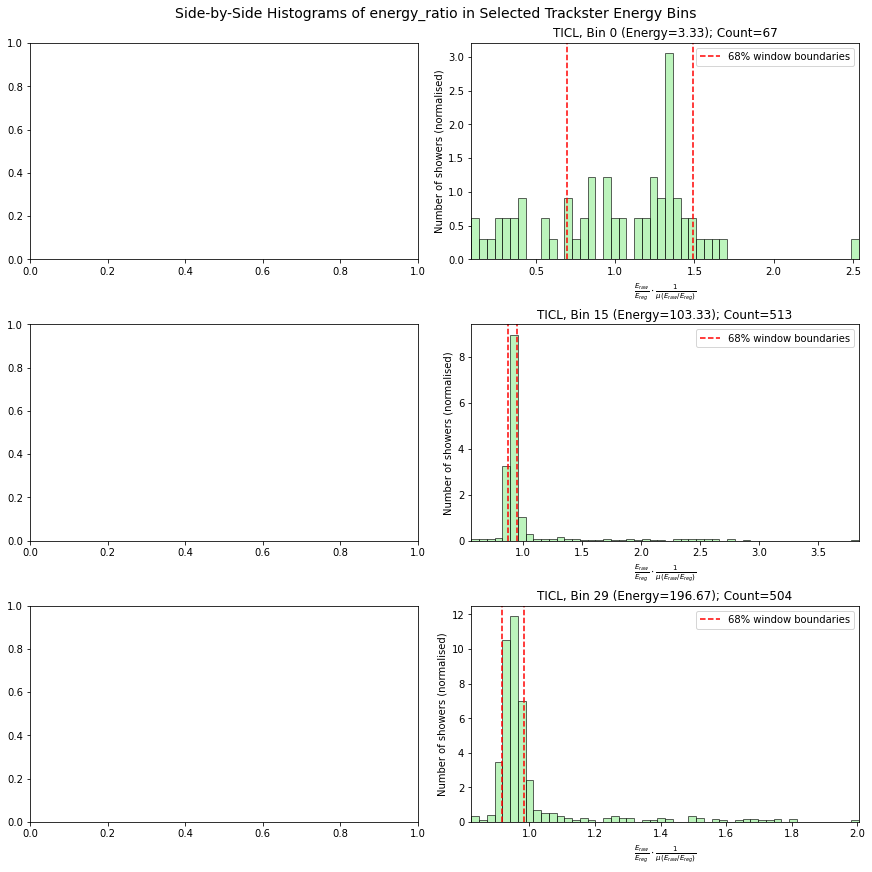

In [36]:
# ====================================================
# 4. Plot Side-by-Side Histograms for Selected Bins (DEBUGGING)
# ====================================================
selected_bins = [0, n_bins // 2, n_bins - 1]
n_sel = len(selected_bins)
fig_hist, axs = plt.subplots(n_sel, 2, figsize=(12, 4 * n_sel), constrained_layout=True)
#xlim_range = (0, 2)  # Fixed x-axis for all histograms

for i, b in enumerate(selected_bins):
    # For df_TICL histogram:
    data_TICL = df_TICL_best.loc[df_TICL_best['cp_energy_bin'] == b, 'energy_ratio'].dropna()
    ax_right = axs[i, 1] if n_sel > 1 else axs[1]
    
    mean_arith = np.mean(data_TICL)
    scaled_data =  data_TICL / mean_arith
    sorted_data = np.sort(scaled_data)
    n_points = len(sorted_data)
    
    
    window_size = int(np.round(0.683 * n_points))
    if window_size < 1:
        window_size = 1
    min_width = np.inf
    best_range = (None, None)
    for i in range(n_points - window_size + 1):
        width = sorted_data[i + window_size - 1] - sorted_data[i]
        if width < min_width:
            min_width = width
            best_range = (sorted_data[i], sorted_data[i + window_size - 1])
    sigma_eff_this = best_range[1] - best_range[0]
    mu_eff = (best_range[0] + best_range[1]) / 2
    print(mu_eff)
    

    n_TICL, bins_TICL, _ = ax_right.hist(sorted_data, bins=50,
                                          color='lightgreen', alpha=0.6, edgecolor='k',density=True)
    

    x_min = scaled_data.min()
    x_max = scaled_data.max()
    ax_right.set_xlim(x_min, x_max)  # Set dynamic x-limits

    # Fit a normal distribution to the data
    #mu_TICL = fitted_mean_TICL[b] 
    #sigma_TICL = sigma_eff_TICL[b] #<----- quicker way


    ax_right.axvline(best_range[0], color='red', linestyle='--', label='68% window boundaries')
    ax_right.axvline(best_range[1], color='red', linestyle='--')
    #ax_right.axvline(np.mean(data_TICL))

    # Set titles and labels
    ax_right.set_title(f'TICL, Bin {b} (Energy={bin_centers[b]:.2f}); Count={len(data_TICL)}')
    ax_right.set_xlabel(r'$\frac{E_{raw}}{E_{reg}} \cdot \frac{1}{\mu(E_{raw}/E_{reg})}$')
    ax_right.set_ylabel('Number of showers (normalised)')
    ax_right.legend(fontsize=10)
    

plt.suptitle('Side-by-Side Histograms of energy_ratio in Selected Trackster Energy Bins', fontsize=14)
plt.show()

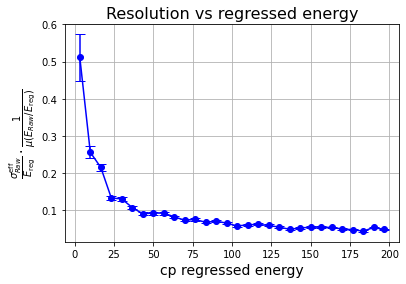

In [16]:
fig, ax = plt.subplots(figure=(8,6))
ax.errorbar(bin_centers, sigma_eff_TICL, yerr=sigma_eff_err_TICL, fmt='bo-', capsize=5, label='TICL')
ax.set_xlabel('cp regressed energy', fontsize=14)
ax.set_ylabel(r'$\frac{\sigma^{\text{eff}}_{Raw}}{E_{\text{reg}}} \cdot \frac{1}{\mu(E_{Raw} / E_{\text{reg}})}$', fontsize=14)
ax.set_title('Resolution vs regressed energy', fontsize=16)
ax.grid(True)
#ax.set_ylim(0,1)
#ax.set_xlim(10,200)
plt.show()

## Final 

268451.9077688304
0.9237236570982761
0.9255618557125012


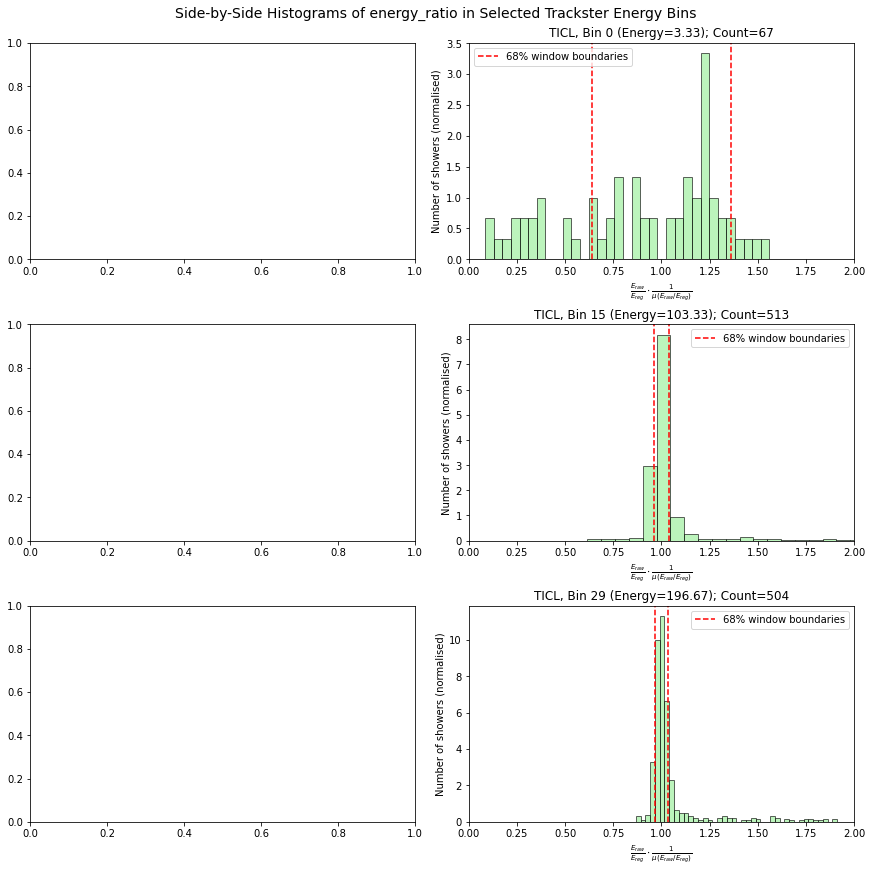

In [21]:
# # ====================================================
# 4. Plot Side-by-Side Histograms for Selected Bins (DEBUGGING)
# ====================================================
selected_bins = [0, n_bins // 2, n_bins - 1]
n_sel = len(selected_bins)
fig_hist, axs = plt.subplots(n_sel, 2, figsize=(12, 4 * n_sel), constrained_layout=True)
#xlim_range = (0, 2)  # Fixed x-axis for all histograms

for i, b in enumerate(selected_bins):
    # For df_TICL histogram:
    data_TICL = df_TICL_best.loc[df_TICL_best['cp_energy_bin'] == b, 'energy_ratio'].dropna()
    ax_right = axs[i, 1] if n_sel > 1 else axs[1]
    
    #mean_arith = np.mean(data_TICL)
    scaled_data =  data_TICL #/ mean_arith
    sorted_data = np.sort(scaled_data)
    n_points = len(sorted_data)
    
    
    window_size = int(np.round(0.683 * n_points))
    if window_size < 1:
        window_size = 1
    min_width = np.inf
    best_range = (None, None)
    for i in range(n_points - window_size + 1):
        width = sorted_data[i + window_size - 1] - sorted_data[i]
        if width < min_width:
            min_width = width
            best_range = (sorted_data[i], sorted_data[i + window_size - 1])
    sigma_eff_this = best_range[1] - best_range[0]
    mu_eff = (best_range[0] + best_range[1]) / 2
    print(mu_eff)
    

    n_TICL, bins_TICL, _ = ax_right.hist(sorted_data / mu_eff, bins=50,
                                          color='lightgreen', alpha=0.6, edgecolor='k',density=True)
    

    x_min = scaled_data.min()
    x_max = scaled_data.max()
    ax_right.set_xlim(0, 2)  # Set dynamic x-limits

    # Fit a normal distribution to the data
    #mu_TICL = fitted_mean_TICL[b] 
    #sigma_TICL = sigma_eff_TICL[b] #<----- quicker way


    ax_right.axvline(best_range[0] / mu_eff, color='red', linestyle='--', label='68% window boundaries')
    ax_right.axvline(best_range[1] / mu_eff, color='red', linestyle='--')
    #ax_right.axvline(np.mean(data_TICL))

    # Set titles and labels
    ax_right.set_title(f'TICL, Bin {b} (Energy={bin_centers[b]:.2f}); Count={len(data_TICL)}')
    ax_right.set_xlabel(r'$\frac{E_{raw}}{E_{reg}} \cdot \frac{1}{\mu(E_{raw}/E_{reg})}$')
    ax_right.set_ylabel('Number of showers (normalised)')
    ax_right.legend(fontsize=10)
    

plt.suptitle('Side-by-Side Histograms of energy_ratio in Selected Trackster Energy Bins', fontsize=14)
plt.show()

30
30
30
30


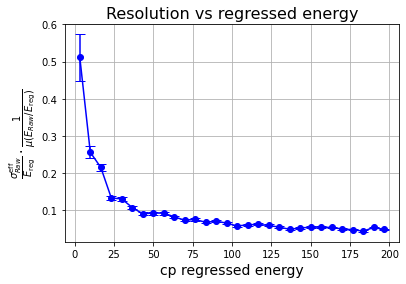

In [20]:
def compute_sigma_effective_scaled(df, n_bins):
    sigma_eff_vals = []
    sigma_eff_errs = []
    fitted_mean_vals = []
    counts = []
    
    for b in range(n_bins):
        bin_data = df.loc[df['cp_energy_bin'] ==b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        
        if len(bin_data) == 0:
            sigma_eff_vals.append(np.nan)
            sigma_eff_errs.append(np.nan)
            fitted_mean_vals.append(np.nan)
            continue
        
        #mean_arith = np.mean(bin_data)
        scaled_data =  bin_data #/ mean_arith
        sorted_data = np.sort(scaled_data)
        n_points = len(sorted_data)
        

        
        window_size = int(np.round(0.683 * n_points))
        if window_size < 1:
            window_size = 1
        
        min_width = np.inf
        best_range = (None, None)
        for i in range(n_points - window_size + 1):
            width = sorted_data[i + window_size - 1] - sorted_data[i]
            if width < min_width:
                min_width = width
                best_range = (sorted_data[i], sorted_data[i + window_size - 1])
        
        mu_eff = (best_range[0] + best_range[1]) / 2 
        fitted_mean_vals.append(mu_eff / mu_eff)
        
        sigma_eff = (best_range[1] - best_range[0] ) / np.sqrt(2)
        sigma_eff_err = sigma_eff / np.sqrt(n_points) if n_points > 1 else np.nan
        sigma_eff_vals.append(sigma_eff / mu_eff)
        sigma_eff_errs.append(sigma_eff_err / mu_eff)
        
    return np.array(fitted_mean_vals), np.array(sigma_eff_vals), np.array(sigma_eff_errs), np.array(counts)

fitted_mean_TICL, sigma_eff_TICL, sigma_eff_err_TICL, counts_TICL = compute_sigma_effective_scaled(df_TICL_best, n_bins)
print(len(sigma_eff_TICL))
print(len(fitted_mean_TICL))
print(len(bin_centers))
print(n_bins)

fig, ax = plt.subplots(figure=(8,6))
ax.errorbar(bin_centers, sigma_eff_TICL, yerr=sigma_eff_err_TICL, fmt='bo-', capsize=5, label='TICL')
ax.set_xlabel('cp regressed energy', fontsize=14)
ax.set_ylabel(r'$\frac{\sigma^{\text{eff}}_{Raw}}{E_{\text{reg}}} \cdot \frac{1}{\mu(E_{Raw} / E_{\text{reg}})}$', fontsize=14)
ax.set_title('Resolution vs regressed energy', fontsize=16)
ax.grid(True)
#ax.set_ylim(0,0.1)
#ax.set_xlim(10,200)
plt.show()